In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json


In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

## Dataset

In [5]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png_128')
os.listdir(PATH)

['train', 'tmp', 'models', 'valid', 'test']

In [6]:
sz = 128
bs = 64
nw = 16

aug_tfms = []

In [7]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))
#train_ids_150 = [s[len(TRAIN_DATA)+1:-5] for s in train_files_150]
#train_ids_150[:5]

In [8]:
TRAIN_DATA_x

'/home/ubuntu/fastai/data/roads/mass_roads_png_128/train/sat'

In [9]:
!ls {TRAIN_DATA_x} | wc -l

7014


In [10]:
VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))


In [11]:
img = Image.open(trn_x[0])
np.asarray(img).shape

(128, 128, 3)

In [12]:
img = Image.open(trn_y[0])
np.asarray(img).shape

(128, 128)

In [13]:
print('Len train sat: {} len train mask: {}'.format(len(trn_x), len(trn_y)))
print('Len valid sat: {} Len Valid mask: {}'.format(len(val_x), len(val_y)))

Len train sat: 7014 len train mask: 7014
Len valid sat: 460 Len Valid mask: 460


In [5]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [30]:
#tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=[])
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [31]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

y[2].shape

(128, 128, 3)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

## Model

In [7]:
f = resnet34
cut,lr_cut = model_meta[f]

In [8]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [9]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

In [10]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

In [11]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [12]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)        
        x = self.up4(x)
        x = self.up5(x)
        return x

In [20]:
m_base = get_base()

In [13]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [22]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [42]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [43]:
learn.freeze_to(1)

 85%|████████▍ | 93/110 [00:45<00:08,  2.03it/s, loss=3.69] 

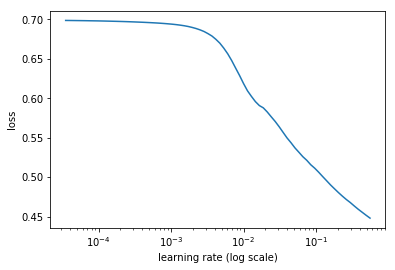

In [45]:
learn.lr_find()
learn.sched.plot()

In [46]:
lr=2e-1

In [48]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

  8%|▊         | 9/110 [00:05<01:04,  1.57it/s, loss=0.519]
epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.293792   0.26809    0.911402   0.000354  
    1      0.255303   0.23082    0.913039   0.114181         
    2      0.233504   0.217384   0.91609    0.259491         
    3      0.219544   0.210178   0.917619   0.373838         



[0.21017798405626545, 0.9176187261291172, 0.37383789238722426]

 79%|███████▉  | 87/110 [00:42<00:11,  2.04it/s, loss=1.13] 

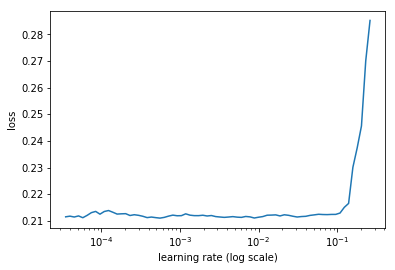

In [49]:
learn.lr_find()
learn.sched.plot()

In [51]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

 12%|█▏        | 13/110 [00:07<00:56,  1.73it/s, loss=0.216]
epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.261772   0.215676   0.916507   0.310645  
    1      0.220452   0.212835   0.917952   0.332893         
    2      0.208057   0.211621   0.916966   0.396207         
    3      0.197243   0.208897   0.91882    0.404731         



[0.20889691632726917, 0.9188200577445652, 0.4047310844711635]

In [52]:
learn.save('128')

In [53]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

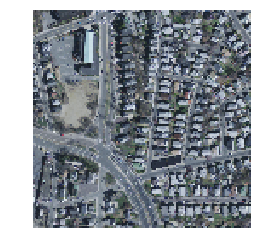

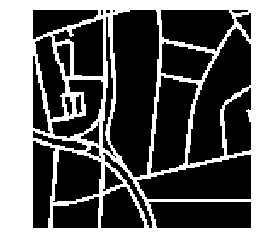

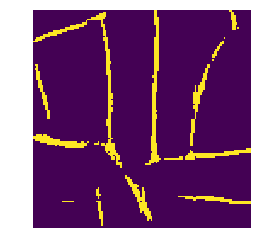

In [54]:
show_img((x[3,:].transpose(0,2).transpose(0,1)+2.5)/5)
show_img(y[3])
show_img(py[3][0]>0);

## U-net - kinda

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [20]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [21]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x

In [58]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [59]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

In [60]:
learn.freeze_to(1)

 84%|████████▎ | 92/110 [00:43<00:08,  2.12it/s, loss=4.58] 

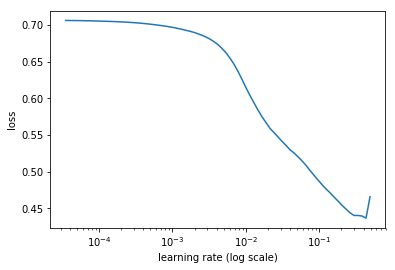

In [62]:
learn.lr_find()
learn.sched.plot()

In [63]:
lr = 1e-1

In [65]:
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

  4%|▎         | 4/110 [00:02<01:15,  1.40it/s, loss=0.682]
epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.224872   0.196372   0.925433   0.475303  
    1      0.199483   0.175775   0.931847   0.528264         
    2      0.189396   0.170287   0.933478   0.557298         
    3      0.183168   0.16785    0.934444   0.576062         
    4      0.176786   0.166789   0.935105   0.535397         
    5      0.169927   0.166089   0.935548   0.547052         
    6      0.16342    0.169137   0.935783   0.575229         
    7      0.155692   0.172323   0.934575   0.592378         



[0.17232333629027657, 0.9345752218495245, 0.5923782488574152]

In [66]:
learn.save('128urn-tmp')

In [75]:
learn.load('128urn-tmp')

In [73]:
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/100,lr/10,lr])

In [74]:
learn.fit(lrs,1,cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.15984    0.205362   0.931776   0.464826  
    1      243.666898 2.390058   0.863533   0.234838        
    2      27.732406  0.505244   0.872897   0.210894        
    3      3.27291    0.243251   0.910604   0.01911         
    4      0.583351   0.241861   0.910778   0.017542         
    5      0.294655   0.238143   0.910351   0.046322         
    6      0.264723   0.240234   0.908346   0.157107         
    7      0.260832   0.239077   0.910873   0.01901          
    8      0.256604   0.242906   0.911146   0.006116         
    9      0.251686   0.240246   0.911112   0.009945         
    10     0.269595   0.485329   0.911415   0.0              
    11     0.267659   0.232016   0.910883   0.060919         
    12     0.250352   0.238229   0.911243   0.01239          
 25%|██▍       | 27/110 [00:17<00:55,  1.51it/s, loss=0.251]

KeyboardInterrupt: 

In [71]:
learn.save('128urn-0')

In [ ]:
learn.load('128urn-0')

In [76]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

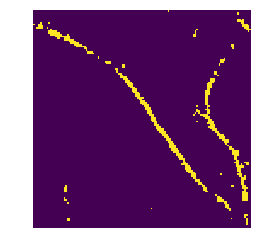

In [77]:
show_img(py[0][0]>0);

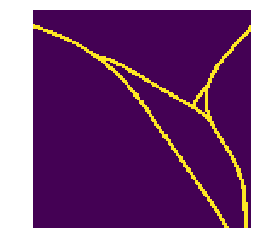

In [78]:
show_img(y[0,...,-1]);

## 512x512

### Data

In [79]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png_512')
os.listdir(PATH)
sz = 512
bs = 16

In [80]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))

VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))

### Model

In [81]:
sz=512
bs=16

In [82]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [83]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [84]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [87]:
learn.load('../../mass_roads_png_128/models/128urn-tmp')

In [89]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

  3%|▎         | 2/70 [00:03<02:09,  1.90s/it, loss=0.106]
epoch      trn_loss   val_loss   mask_acc   dice           
    0      0.107735   0.108347   0.959765   0.510931  
    1      0.108844   0.112663   0.956712   0.598676       
    2      0.103842   0.110218   0.961368   0.550935       
    3      0.101563   0.103616   0.961943   0.597117        
    4      0.093461   0.107135   0.96226    0.573635        



[0.10713536895456768, 0.9622602897977072, 0.5736351041566758]

In [90]:
learn.save('512urn-tmp')

 79%|███████▊  | 55/70 [01:26<00:23,  1.57s/it, loss=0.454] 

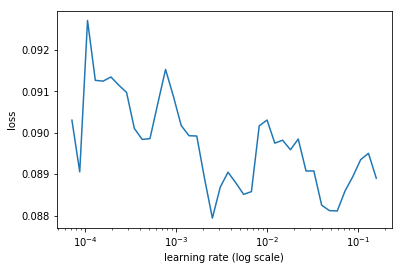

In [91]:
learn.lr_find()
learn.sched.plot()

In [97]:
lr=2e-3

In [99]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

  3%|▎         | 2/70 [00:03<02:09,  1.91s/it, loss=0.124]
epoch      trn_loss   val_loss   mask_acc   dice            
    0      0.097556   0.103728   0.961747   0.571549  
    1      0.092173   0.10591    0.961778   0.577363        
    2      0.089682   0.106872   0.961997   0.567373        
    3      0.087562   0.10815    0.961772   0.572496        
    4      0.087638   0.108663   0.961784   0.574112        



[0.10866286487333358, 0.961784423343719, 0.5741116366689167]

In [100]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

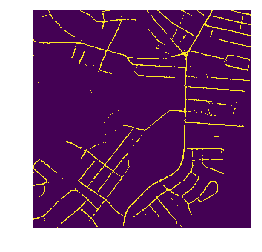

In [101]:
show_img(py[0][0]>0);

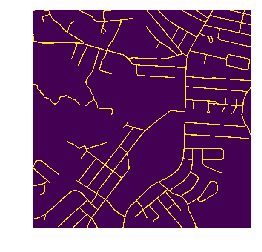

In [102]:
show_img(y[0,...,-1]);

## 1024x1024

### Data

In [14]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png_1024')
os.listdir(PATH)

['train', 'tmp', 'models', 'valid', 'test']

In [15]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))

VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))

### Model

In [16]:
sz=1024
bs=4
aug_tfms=[]

In [17]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [22]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [23]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [24]:
learn.load('../../mass_roads_png_512/models/512urn-tmp')

In [25]:
lr = 1e-1

In [26]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.102729   0.092888   0.965935   0.679643  
    1      0.091198   0.078599   0.970733   0.681883          



[0.07859900227141758, 0.9707327191791837, 0.6818831544073801]

In [27]:
learn.save('1024urn-tmp')

In [28]:
learn.unfreeze()
learn.bn_freeze(True)

In [31]:
lrs = np.array([lr/100,lr/10,lr])

In [32]:
learn.fit(lrs/2,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice              
    0      0.100541   0.082486   0.969512   0.702226  
    1      0.083927   0.074963   0.971824   0.708823          
    2      0.086653   0.074916   0.972519   0.72814           
    3      0.087394   0.071272   0.973301   0.713838          



[0.071272171856392, 0.9733005544495961, 0.7138381467925178]

In [33]:
learn.save('1024urn')

In [34]:
learn.load('1024urn')

In [35]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

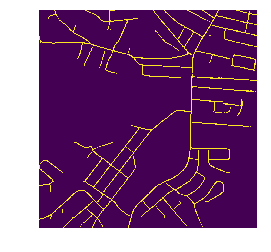

In [36]:
show_img(py[0][0]>0);

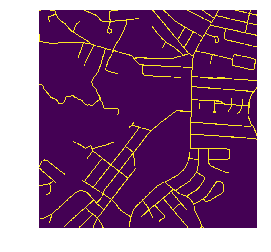

In [37]:
show_img(y[0,...,-1]);

## 1500x1500

### Data

In [38]:
PATH = Path('/home/ubuntu/fastai/data/roads/mass_roads_png')
os.listdir(PATH)

['train', 'valid', 'test']

In [39]:
TRAIN_DATA_x = '{}/train/sat'.format(PATH)
TRAIN_DATA_y = '{}/train/map'.format(PATH)
trn_x = glob(os.path.join(TRAIN_DATA_x, "*.png"))
trn_y = glob(os.path.join(TRAIN_DATA_y, "*.png"))

VALID_DATA_x = '{}/valid/sat'.format(PATH)
VALID_DATA_y = '{}/valid/map'.format(PATH)
val_x = glob(os.path.join(VALID_DATA_x, "*.png"))
val_y = glob(os.path.join(VALID_DATA_y, "*.png"))

### Model

In [40]:
sz=1500
bs=1
aug_tfms=[]

In [41]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [42]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UpsampleModel(m)

In [43]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

learn.freeze_to(1)

In [46]:
learn.load('../../mass_roads_png_1024/models/1024urn')

In [49]:
np.asarray(Image.open(trn_x[0])).shape

(1500, 1500, 3)

In [50]:
np.asarray(Image.open(trn_y[0])).shape

(1500, 1500)

In [51]:
np.asarray(Image.open(val_x[0])).shape

(1500, 1500, 3)

In [52]:
np.asarray(Image.open(val_y[0])).shape

(1500, 1500)

In [47]:
lr = 1e-1

In [48]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

  0%|          | 0/1108 [00:00<?, ?it/s]


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 375 and 376 in dimension 2 at /opt/conda/conda-bld/pytorch_1525812548180/work/aten/src/THC/generic/THCTensorMath.cu:111